In [12]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np

In [13]:
model = Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(100, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [14]:
TRAINING_DIR = "./train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "./test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))

Found 1315 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [15]:
#Initialize a callback checkpoint to keep saving best model after each epoch while training:
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')

In [16]:
history = model.fit_generator(train_generator,
                              epochs=25,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Epoch 1/25
132/132 [==============================] - 95s 716ms/step - loss: 0.5757 - acc: 0.7027 - val_loss: 0.0325 - val_acc: 0.9113

Epoch 00001: val_loss improved from inf to 0.03249, saving model to model2-001.model
Epoch 2/25
132/132 [==============================] - 92s 700ms/step - loss: 0.3410 - acc: 0.8639 - val_loss: 0.0140 - val_acc: 0.9597

Epoch 00002: val_loss improved from 0.03249 to 0.01395, saving model to model2-002.model
Epoch 3/25
132/132 [==============================] - 91s 693ms/step - loss: 0.3023 - acc: 0.8852 - val_loss: 0.0631 - val_acc: 0.9597

Epoch 00003: val_loss did not improve from 0.01395
Epoch 4/25
132/132 [==============================] - 92s 694ms/step - loss: 0.2253 - acc: 0.9179 - val_loss: 0.0431 - val_acc: 0.9677

Epoch 00004: val_loss did not improve from 0.01395
Epoch 5/25
132/132 [==============================] - 95s 723ms/step - loss: 0.2291 - acc: 0.9095 - val_loss: 0.0388 - val_acc: 0.9839

Epoch 00005: val_loss did not improve from 0

In [17]:
model.save('model.h5')
print("Saving the model as model.h5")

Saving the model as model.h5


In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 100)     2800      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 100)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 100)       90100     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 100)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 129600)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 129600)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)               

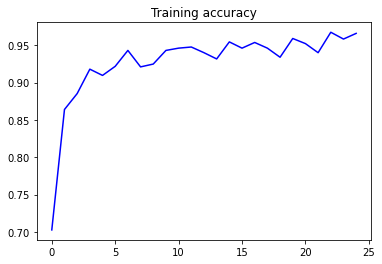

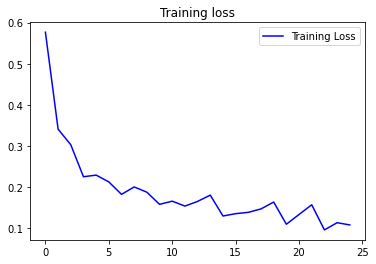

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [20]:
score = model.evaluate(validation_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02689114585518837
Test accuracy: 1.0


In [ ]:
#LIVE VIDEO MASK DETECTION

In [21]:
facecascade = cv2.CascadeClassifier(r"C:\Users\Akanksha\AppData\Local\Programs\Python\Python36\Lib\site-packages\cv2\data\haarcascade_frontalcatface.xml")
test=facecascade.load(r"C:\Users\Akanksha\AppData\Local\Programs\Python\Python36\Lib\site-packages\cv2\data\haarcascade_frontalcatface.xml")
print(test)

True


In [40]:
model=load_model("model.h5")
results={0:'without mask',1:'mask'}
GR_dict={0:(0,0,255),1:(0,255,0)}
rect_size = 4
cap = cv2.VideoCapture(0) 
haarcascade = cv2.CascadeClassifier(r"C:\Users\Akanksha\AppData\Local\Programs\Python\Python36\Lib\site-packages\cv2\data\haarcascade_frontalcatface.xml")
while (True):
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 
    
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    cv2.imshow('LIVE MASK DETECTION',im)
    key = cv2.waitKey(10)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()
